In [ ]:
# default_exp protocol

# Protocol

> Representation of quantum protocol.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import networkx as nx
from simpleeval import simple_eval, DEFAULT_FUNCTIONS
from functools import lru_cache, cached_property
import dill as pickle

from qsample.circuit import Circuit,unpack

In [ ]:
#export
class Protocol:
    """Representation of a Quantum protocol"""
    
    def __init__(self, fault_tolerant=False, *args, **kwargs):
        self.graph = nx.DiGraph(*args, **kwargs)
        self.fault_tolerant = fault_tolerant
        self._check_fns = DEFAULT_FUNCTIONS.copy()
        self._check_fns.update(len=len, bin=bin)
        self._circuits = {}
        
    @property
    def n_qubits(self):
        return len(set(qb for c in self._circuits.values() for qb in unpack(c)))
        
    def add_node(self, name, circuit):
        self._circuits[circuit.id] = circuit
        self.graph.add_node(name, circuit_id=circuit.id)
        
    def add_edge(self, *args, **kwargs):
        self.graph.add_edge(*args, **kwargs)
    
    def add_nodes_from(self, *args, **kwargs):
        self.graph.add_nodes_from(*args, **kwargs)
    
    def update_node(self, node, circuit):
        self._circuits[circuit.id] = circuit
        self.graph.nodes[node]['circuit_id'] = circuit.id
        
    def add_nodes_from(self, names, circuits):
        if not isinstance(circuits, (list,tuple,set)):
            circuits = [circuits] * len(names)
        for name, circuit in zip(names, circuits):
            self.add_node(name, circuit)

    @cached_property
    def partition(self):
        return {cid: circ.partition for cid,circ in self._circuits.items()}
    
    @lru_cache(maxsize=128)
    def checks(self, node):
        adj_nodes = self.graph.out_edges(node)
        return {pair[1]: self.graph.edges[pair]['check'] for pair in adj_nodes}
    
    def save(self, path):
        with open(path, 'wb') as fp:
            pickle.dump(self, fp)
            
    def load(self, path):
        with open(path, 'rb') as fp:
            res = pickle.load(fp)
        self._circuits = res._circuits
        self._check_fns = res._check_fns
        self.fault_tolerant = res.fault_tolerant
        return self
    
    def __iter__(self):
        node = 'START'
        hist = {}
        name_handler = lambda ast_node: hist.get(ast_node.id, None)
        
        while node:
        
            checks = {n: simple_eval(check, names=name_handler, functions=self._check_fns)
                     for n,check in self.checks(node).items()}
            next_nodes = [(nn,check) for nn,check in checks.items() if check]
            
            if len(next_nodes) == 0:
                node = None
            elif len(next_nodes) == 1:
                node, check_ret = next_nodes[0]
                
                if isinstance(check_ret, Circuit):
                    self.update_node(node, check_ret)
                
                if not self.graph.out_edges(node): break
                
                circuit_id = self.graph.nodes(data='circuit_id')[node]
                circuit = self._circuits[circuit_id]
                yield node, circuit
                hist[node] = hist.get(node,[]) + [self.msmt]
            else: 
                raise Exception(f"Too many checks True for node {node}.")
                
        yield node, None
            
                
    def send(self, msmt):
        if msmt: self.msmt = int(msmt,2)
        else: self.msmt = None
        
    def draw(self, path=None, legend=False, figsize=(6,6), label_offset=(0.05,0.05)):
        import matplotlib.pyplot as plt
        plt.figure(figsize=figsize)
        
        pos = nx.kamada_kawai_layout(self.graph)
        size = max([len(n)**2 * 100 for n in pos.keys()])
        col = ['#ff9999' if not self.graph.out_edges(n) else '#d3d3d3' if not self.graph.in_edges(n) else 'white' for n in self.graph.nodes]
        nx.draw(self.graph, pos=pos, with_labels=True, node_color=col, node_size=size, edgecolors='black')
        
        edge_lbls = nx.get_edge_attributes(self.graph, 'check')
        if legend:
            import matplotlib.lines as mlines
            n_edge_lbls, legend_lbls = dict(), []
            edge_cnt = 0
            for (to,fr),lbl in edge_lbls.items():
                if lbl == 'True': n_edge_lbls[(to,fr)] = lbl
                else: 
                    edge_cnt += 1
                    n_edge_lbls[(to,fr)] = f"${edge_cnt}$"
                    leg_lbl = mlines.Line2D([], [], color='black', marker=f'${edge_cnt}$', linestyle='None', markersize=8, label=lbl)
                    legend_lbls.append(leg_lbl)
            lgd = plt.legend(handles=legend_lbls, bbox_to_anchor=(1.04, 1), loc="upper left")
            edge_lbls = n_edge_lbls
            
        dx, dy = label_offset
        loop_pos = {n:(x+dx, y+dy) for n,(x,y) in pos.items()}
        loop_lbls = {(to,fr): lbl for (to,fr), lbl in edge_lbls.items() if to==fr}
        lbls = {(to,fr): lbl for (to,fr), lbl in edge_lbls.items() if to!=fr}
        edge_box = dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
        nx.draw_networkx_edge_labels(self, pos, lbls, font_size=12, bbox=edge_box, rotate=False if legend else True)
        nx.draw_networkx_edge_labels(self, loop_pos, loop_lbls, font_size=12, bbox=edge_box, rotate=True)
        
        if path and legend: plt.savefig(save_path, bbox_extra_artists=(lgd,), bbox_inches='tight')
        elif path: plt.savefig(path, bbox_inches='tight')

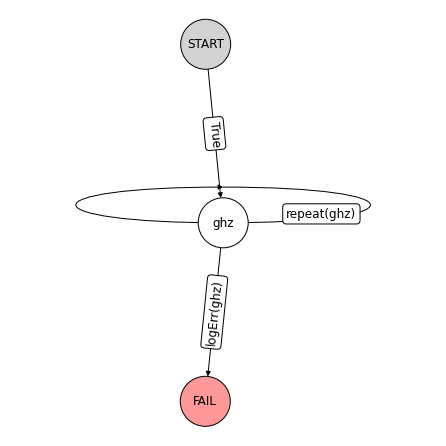

In [ ]:

from qsample.circuit import Circuit

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ], ff_det=True)

def gen_ghz3():
    
    def repeat(m):
        return len(m) < 3 and m[-1] == 1

    def logErr(m):
        return len(m) >= 3 and m == [1,1,1]

    functions = {'logErr': logErr, 'repeat': repeat}

    ghz3 = Protocol()
    ghz3._check_fns.update(functions)
    ghz3._ft = True
    
    ghz3.add_nodes_from(['ghz'], circuits=[ghz])
    
    ghz3.add_edge('START', 'ghz', check='True')
    ghz3.add_edge('ghz', 'ghz', check='repeat(ghz)')
    ghz3.add_edge('ghz', 'FAIL', check='logErr(ghz)')
    
    return ghz3
ghz3 = gen_ghz3()
ghz3.draw()